## Plan
1. Clean data (if necessary)
2. Put data into a suitable data structure
3. Train models

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [23]:
ruta_raiz = os.path.dirname(os.getcwd()) 
ruta_csv = os.path.join(ruta_raiz, "data", "home-credit-default-risk", "application_train.csv")
data = pd.read_csv(ruta_csv)

In [24]:
print(data.columns.tolist())

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELE

The first thing I will do is to create new variables that will better suit the models.

In [25]:
data = data.assign(
    AGE = abs(data['DAYS_BIRTH']) / 365,
    YEARS_EMPLOYED = abs(data['DAYS_EMPLOYED']) / 365,
    INCOME_PER_CHILD = data['AMT_INCOME_TOTAL'] / (data['CNT_CHILDREN'] + 1),
    PAYMENT_RATE = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL'],
    CREDIT_GOODS_RATIO = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE'],
    CREDIT_DOWNPAYMENT = data['AMT_GOODS_PRICE'] - data['AMT_CREDIT']
)

Payment rate tells me the percentage of the borrowers monthly income that each payment represents.

In [26]:
correlations = data.corr(numeric_only=True)['TARGET'].sort_values()

print("\nFeatures with the highest negative correlation (reduce risk)")
print(correlations.head(15))


print("\nFeautres with the highest positive correlation (increase risk)")
print(correlations.tail(15))


Features with the highest negative correlation (reduce risk)
EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
AGE                          -0.078239
YEARS_EMPLOYED               -0.047046
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
CREDIT_DOWNPAYMENT           -0.034254
ELEVATORS_AVG                -0.034199
ELEVATORS_MEDI               -0.033863
FLOORSMIN_AVG                -0.033614
Name: TARGET, dtype: float64

Feautres with the highest positive correlation (increase risk)
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE      

In [27]:
def plot_distribution(df, column, title):
    plt.figure(figsize=(10,6))
    sns.histplot(df[column].dropna(), kde=True, color='green')
    plt.title(title)
    plt.show()

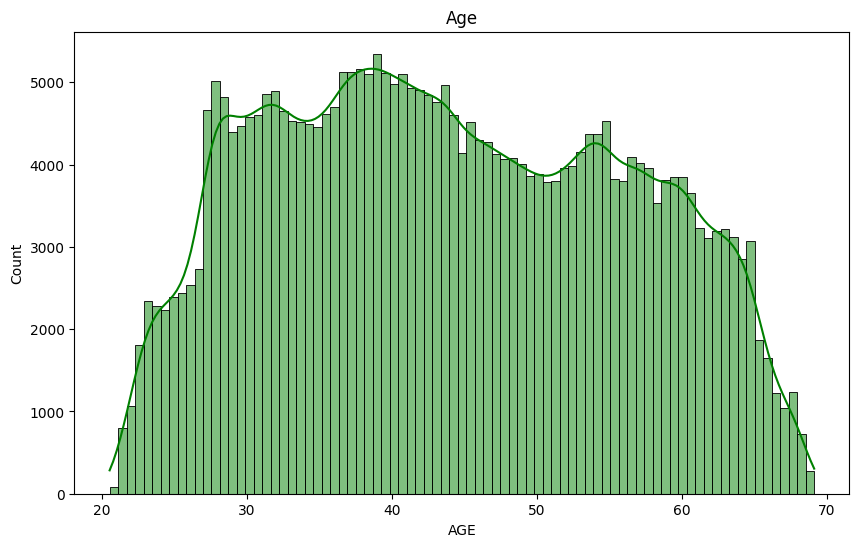

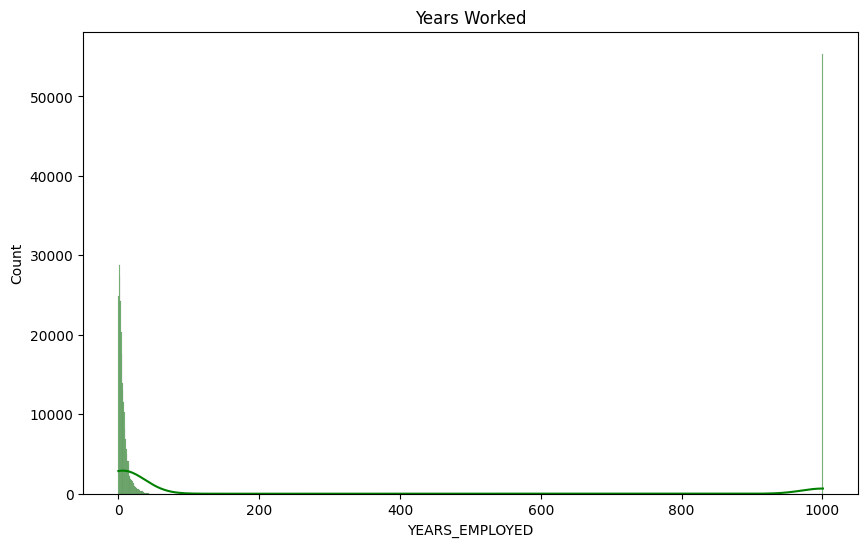

In [28]:
plot_distribution(data, "AGE", "Age")
plot_distribution(data, "YEARS_EMPLOYED", "Years Worked")

It looks like the dataset uses the number 365243 as a way to show a borrower is retired. I will use this to create a new variable that informs wether a borrower is retired.

In [29]:
data["IS_RETIRED"] = (data["DAYS_EMPLOYED"] == 365243).astype(int)
data["DAYS_EMPLOYED_CLEAN"] = data["DAYS_EMPLOYED"].replace(365243, 0)
data["YEARS_EMPLOYED_CLEAN"] = abs(data["DAYS_EMPLOYED_CLEAN"]) / 365

I had a choice to either fill the 365243 with 0's or with the Median value. The problem with filling it with the median value is those unemployed entries would be interpreted as 4-5 years of experience, which is clearly false.

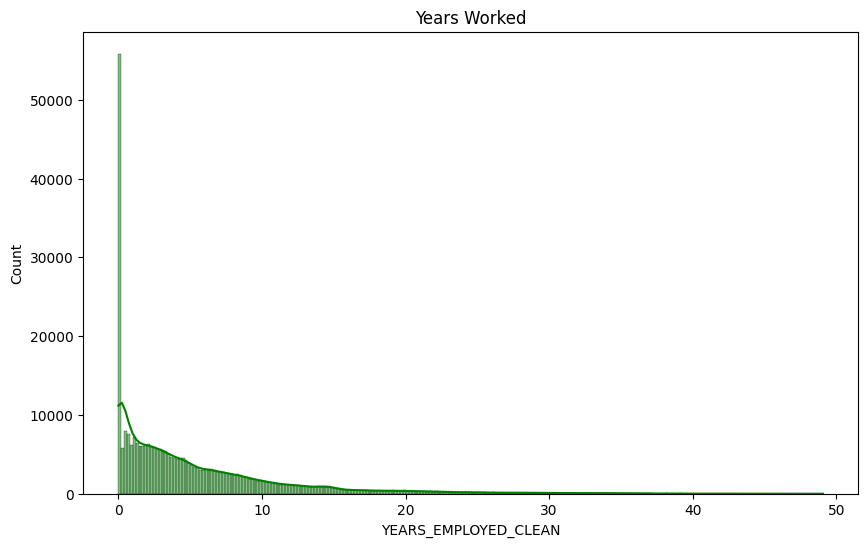

In [30]:
plot_distribution(data, "YEARS_EMPLOYED_CLEAN", "Years Worked")


To see the Income data properly, I will filter some of the highest income entries that skews the graph.

In [31]:
print(data['AMT_INCOME_TOTAL'].sort_values(ascending=False).head(10))

12840     117000000.0
203693     18000090.0
246858     13500000.0
77768       9000000.0
131127      6750000.0
103006      4500000.0
287463      4500000.0
187833      4500000.0
204564      4500000.0
181698      3950059.5
Name: AMT_INCOME_TOTAL, dtype: float64


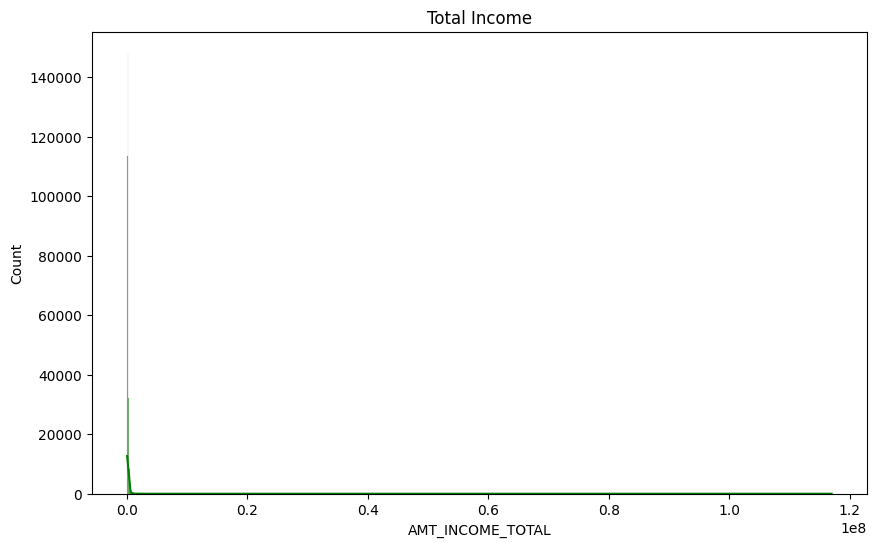

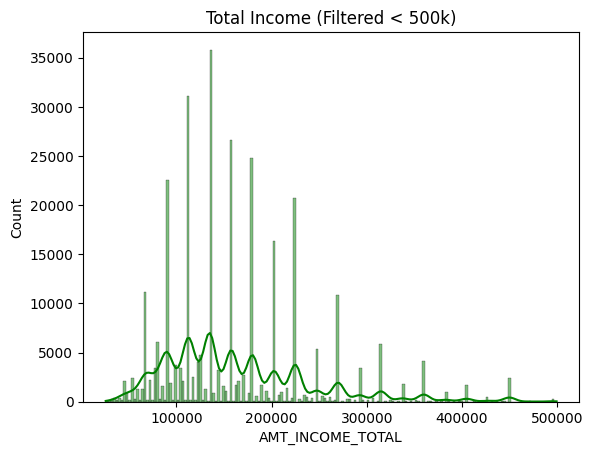

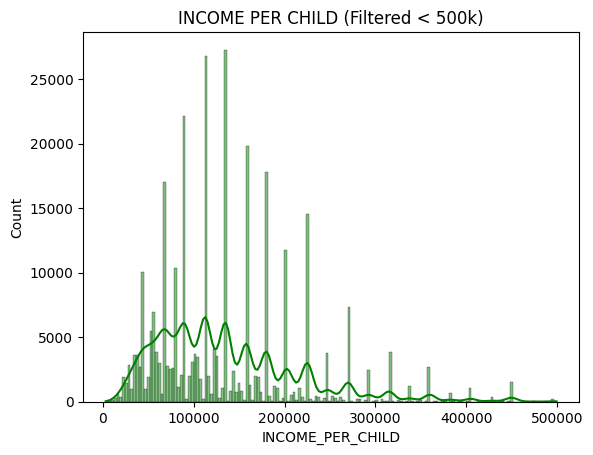

In [32]:
plot_distribution(data, "AMT_INCOME_TOTAL", "Total Income")

sns.histplot(data[data['AMT_INCOME_TOTAL'] < 500000]['AMT_INCOME_TOTAL'], kde=True, color='green')
plt.title('Total Income (Filtered < 500k)')
plt.show()

sns.histplot(data[data["AMT_INCOME_TOTAL"] < 500000]["INCOME_PER_CHILD"], kde=True, color='green')
plt.title('INCOME PER CHILD (Filtered < 500k)')
plt.show()

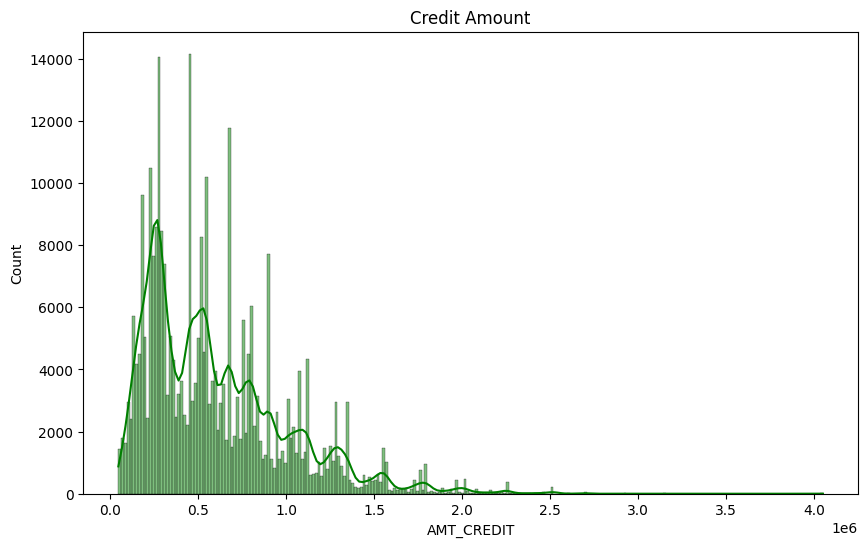

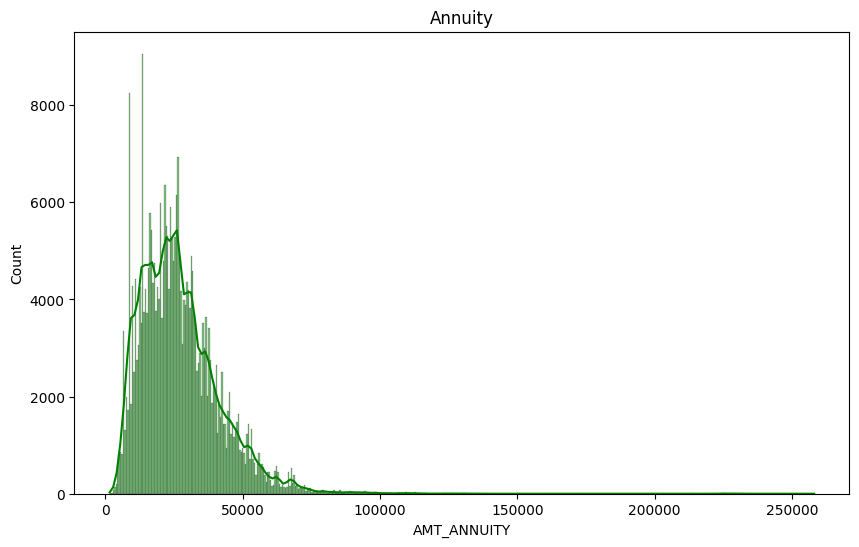

In [33]:
plot_distribution(data, "AMT_CREDIT", "Credit Amount")
plot_distribution(data, "AMT_ANNUITY", "Annuity")


## Structure Data


In [34]:
cols_to_use = [
    'AMT_CREDIT', 'AMT_ANNUITY', 'YEARS_EMPLOYED_CLEAN', 
    'INCOME_PER_CHILD', 'PAYMENT_RATE', 'CREDIT_GOODS_RATIO', 'CREDIT_DOWNPAYMENT',
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'REGION_RATING_CLIENT', 'IS_RETIRED'
]

X = data[cols_to_use]
y = data["TARGET"]

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

scaler = StandardScaler()

cols_to_scale = [
    'AMT_CREDIT', 'AMT_ANNUITY', 'YEARS_EMPLOYED_CLEAN', 
    'INCOME_PER_CHILD', 'PAYMENT_RATE', 'CREDIT_GOODS_RATIO', 'CREDIT_DOWNPAYMENT'
]

cols_to_keep = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'REGION_RATING_CLIENT', 'IS_RETIRED']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, cols_to_scale)
    ],
    remainder='passthrough' # Mantiene las columnas de 'cols_to_keep' sin cambios
)

features = cols_to_scale + cols_to_keep
# 'AMT_CREDIT', 'AMT_ANNUITY', 'YEARS_EMPLOYED_CLEAN', 
# 'INCOME_PER_CHILD', 'PAYMENT_RATE', 'CREDIT_GOODS_RATIO', 'CREDIT_DOWNPAYMENT',
# 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'REGION_RATING_CLIENT', 'IS_RETIRED'

X_train_scaled = pd.DataFrame(preprocessor.fit_transform(X_train[cols_to_use]), columns=features)
X_test_scaled = pd.DataFrame(preprocessor.transform(X_test[cols_to_use]), columns=features)



## Training the Models

In [39]:
from sklearn.impute import SimpleImputer

# columns which I decided to fill with the median
cols_to_fill = [
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'INCOME_PER_CHILD', 'AMT_ANNUITY', 'REGION_RATING_CLIENT', 'PAYMENT_RATE',
    'CREDIT_GOODS_RATIO', 'CREDIT_DOWNPAYMENT'
]

imputer = SimpleImputer(strategy='median')

X_train_imputed = imputer.fit_transform(X_train[cols_to_fill])
X_test_imputed = imputer.transform(X_test[cols_to_fill])

### Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(class_weight='balanced', max_iter=1000)

model.fit(X_train_imputed, y_train)

predictions_LR = model.predict(X_test_imputed)

precision = accuracy_score(y_test, predictions_LR)

print(precision)

0.6781295221371315


In [43]:
from sklearn.metrics import confusion_matrix

def build_CM(y_test, predictions):
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
    plt.title('Confusion Matrix (Balanced Model)')
    plt.ylabel('Value')
    plt.xlabel('Prediction')
    plt.show()

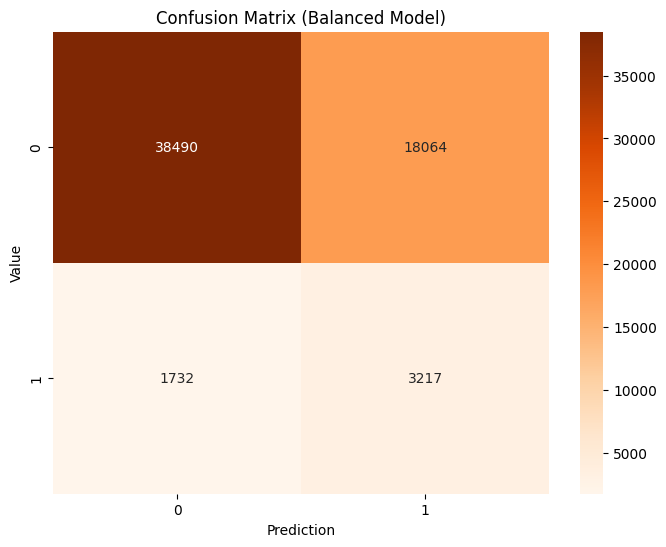

              precision    recall  f1-score   support

           0       0.96      0.68      0.80     56554
           1       0.15      0.65      0.25      4949

    accuracy                           0.68     61503
   macro avg       0.55      0.67      0.52     61503
weighted avg       0.89      0.68      0.75     61503



In [44]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

build_CM(y_test, predictions_LR)

print(classification_report(y_test, predictions_LR))

I am using recall to measure the model's performance because I think it is more important to minimize false negatives rather than maximize overall accuracy.

After fine tuning the variables inputted into the model, I have come to the conclusion that the logistic regression model's recall tops out at around 0.65.


### Random Forest


In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    class_weight='balanced', 
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_imputed, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

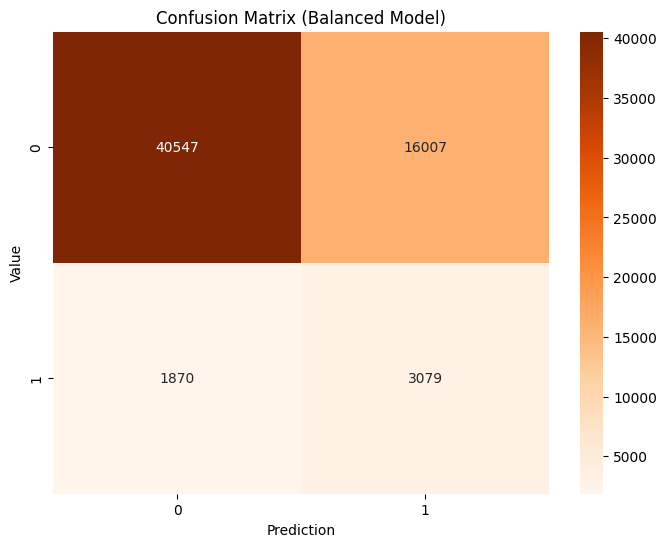

              precision    recall  f1-score   support

           0       0.96      0.72      0.82     56554
           1       0.16      0.62      0.26      4949

    accuracy                           0.71     61503
   macro avg       0.56      0.67      0.54     61503
weighted avg       0.89      0.71      0.77     61503



In [47]:
predictions_rf = rf_model.predict(X_test_imputed)

build_CM(y_test, predictions_rf)

print(classification_report(y_test, predictions_rf))

Very similar result to logistic regression.

### Gradient Boost (XGB)

In [48]:
from xgboost import XGBClassifier

ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,             # Un poco más bajo que RF para evitar overfitting
    learning_rate=0.1,       # Qué tan rápido aprende de los errores
    scale_pos_weight=ratio,  # Vital para el Recall
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

In [49]:
xgb_model.fit(X_train_scaled, y_train)

preds_xgb = xgb_model.predict(X_test_scaled)

c:\Users\andre\Documents\GitHub\end-to-end-credit-scoring\venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [20:39:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


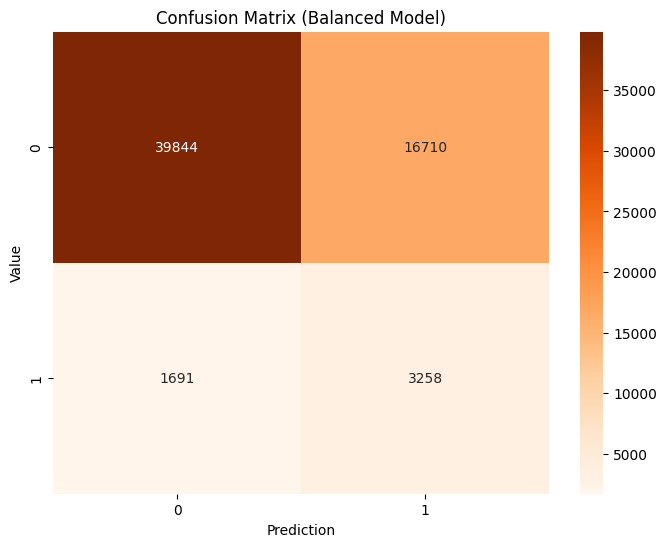

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56554
           1       0.16      0.66      0.26      4949

    accuracy                           0.70     61503
   macro avg       0.56      0.68      0.54     61503
weighted avg       0.90      0.70      0.77     61503



In [50]:
build_CM(y_test, preds_xgb)
print(classification_report(y_test, preds_xgb))


In [52]:
import joblib
joblib.dump(xgb_model, 'credit_score_model.pkl')

['credit_score_model.pkl']

In [53]:
y_probs_all = xgb_model.predict_proba(X_test_scaled[features])[:, 1]
print(f"Min Prob: {y_probs_all.min():.4f} | Max Prob: {y_probs_all.max():.4f}")

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices